# 4_model.ipynb
### Team: *Team Yunus*
### Made By: *Yunus Eren Ertas*
## 1. Load the Prepared Dataset

Before building any models, we load the cleaned and feature-engineered electricity demand dataset.
This dataset has been produced in the previous notebook and already contains consistent timestamps, cleaned numeric values, and correct dtypes.

We convert the index into a datetime index and sort chronologically because:

- Time-series models must follow time order

- Lag features rely on correctly ordered timestamps

- PyCaret requires a clean tabular structure

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pycaret.regression import *
from sklearn.metrics import r2_score, mean_squared_error

# Load cleaned data
df = pd.read_parquet("../data/clean/uk_electricity_hourly.parquet")

# Ensure datetime index
df.index = pd.to_datetime(df.index)
df = df.sort_index()


## 2. Feature Engineering (Time-Series Specific)

Electricity demand is highly structured and depends on:

- Daily cycles (people waking, working, sleeping)

- Weekly cycles (weekday vs weekend)

- Seasonal patterns (winter vs summer)

- Recent historical demand (lags)

- Short-term trends (rolling averages)

We create features to help models learn these relationships.

### Time-based features

- hour: captures daily periodicity

- day_of_week: Monday=0 → Sunday=6

- month: captures seasonal patterns

- week: useful for quarterly/seasonal effects

- is_weekend: binary variable separating weekend behavior

### Lag features

Models should see the previous demand:

- lag_1: demand 1 hour ago

- lag_24: demand same hour yesterday

- lag_168: demand same hour last week

Lag features allow tree models (LightGBM, Random Forest) to learn autocorrelation patterns.

### Rolling averages

Rolling features smooth noise and show the recent trend, e.g.:

- roll_24: 24-hour moving average

- roll_168: weekly moving average

These reduce randomness and help the model understand short-term vs long-term structure.

In [2]:
def add_features(df):
    df = df.copy()

    # time features
    df["hour"] = df.index.hour
    df["day_of_week"] = df.index.dayofweek
    df["month"] = df.index.month
    df["week"] = df.index.isocalendar().week.astype(int)
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)

    # essential lags
    df["lag_1"] = df["demand_mw"].shift(1)
    df["lag_24"] = df["demand_mw"].shift(24)

    # optional lags
    df["lag_168"] = df["demand_mw"].shift(168)

    # rolling features
    df["roll_24"] = df["demand_mw"].shift(1).rolling(24).mean()
    df["roll_168"] = df["demand_mw"].shift(1).rolling(168).mean()

    return df

df = add_features(df)



## 3. Remove Early Rows With Missing Lag Values (Safe Drop)

Even though the cleaned dataset has no NaN, lag/rolling features create NaNs at the beginning of the time series.
We remove only rows where lag_24 is missing because:

- It keeps maximum data

- Ensures all important features exist

- Prevents PyCaret crashing

In [3]:
# SAFE: keep rows only where lag_24 exists
df = df[df["lag_24"].notna()]

In [4]:
print("Final DF shape:", df.shape)
print("NA counts:\n", df.isna().sum())


Final DF shape: (217680, 11)
NA counts:
 demand_mw        0
hour             0
day_of_week      0
month            0
week             0
is_weekend       0
lag_1            0
lag_24           0
lag_168        144
roll_24          0
roll_168       144
dtype: int64


## 4. Train/Test Split (Chronological)

Time-series data must not be randomly split.
We simulate real forecasting by training on past data and testing on future data:

- Training: up to 31 Dec 2023

- Test: from 1 Jan 2024 onward

This ensures no data leakage from future into past.

In [5]:
train = df[: "2023-12-31"]
test  = df["2024-01-01":]

print("Train rows:", train.shape[0])
print("Test rows:", test.shape[0])


Train rows: 201576
Test rows: 16104


## 5. Initialize PyCaret Regression Environment

PyCaret automates:

- preprocessing

- normalization

- multicollinearity removal

- cross-validation

- metric tracking

We configure:

- fold=3: faster CV for big datasets

- remove_multicollinearity: eliminates redundant lags/roll features

- normalize=True: helps distance-based models (KNN, Ridge)

In [6]:
reg = setup(
    data=train,
    target="demand_mw",
    session_id=42,
    fold=3,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.95,
    normalize=True,
    verbose=False
)


## 6. Fast Baseline Model Comparison

We first create a quick baseline model, required by the assignment.
We compare four fast algorithms:

- LightGBM

- Ridge Regression

- Lasso Regression

- kNN Regressor

This gives a fast first model for deployment.

PyCaret returns the model with the highest R².

In [7]:
fast_models = ["lightgbm", "ridge", "lasso", "knn"]
best = compare_models(include=fast_models, sort="R2")
best


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
lightgbm,Light Gradient Boosting Machine,408.2515,307166.6985,554.2173,0.9946,0.0188,0.0137,1.1933
knn,K Neighbors Regressor,484.6213,443142.0104,665.6887,0.9923,0.0232,0.0166,1.1000
ridge,Ridge Regression,941.9227,1606145.1250,1267.3294,0.9719,0.0430,0.0318,0.7367
lasso,Lasso Regression,941.8597,1606149.5833,1267.3311,0.9719,0.0430,0.0318,0.7333


LGBMRegressor(n_jobs=-1, random_state=42)

## 7. Hyperparameter Tuning of Best Model

We tune the selected algorithm using PyCaret’s automated search.

- n_iter=5 = fast tuning

- Optimizing for R² score

This improves model performance without spending too much time.

In [8]:
tuned = tune_model(best, optimize="R2", n_iter=5)
tuned


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,346.8746,228971.0918,478.5092,0.9960,0.0161,0.0117
1,347.0131,234194.7786,483.9368,0.9959,0.0161,0.0116
2,351.3252,235546.2915,485.3311,0.9959,0.0164,0.0118
Mean,348.4043,232904.0539,482.5924,0.9959,0.0162,0.0117
Std,2.0662,2835.2296,2.9428,0.0000,0.0001,0.0001


Fitting 3 folds for each of 5 candidates, totalling 15 fits


LGBMRegressor(bagging_fraction=0.8, bagging_freq=7, feature_fraction=0.8,
              learning_rate=0.4, min_child_samples=16, min_split_gain=0.7,
              n_jobs=-1, num_leaves=90, random_state=42, reg_alpha=1,
              reg_lambda=3)

## 8. Finalize Model (Train on Full Training Data)

Finalizing a tuned model retrains it on:

- the entire training dataset

- using the best-found hyperparameters

This creates the model that will be used in production.

In [9]:
final_model = finalize_model(tuned)
final_model


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['hour', 'day_of_week', 'month',
                                             'week', 'is_weekend', 'lag_1',
                                             'lag_24', 'lag_168', 'roll_24',
                                             'roll_168'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_multicolline...
                 TransformerWrapper(exclude=[],
                                    transformer=RemoveMulticollinearity(threshold=0.95))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 LGBMRegressor(bagging_fraction=0.8, bagging_freq=7,
                               feature_fraction=0.8, learning_rate=0.4,
                               min_child_samples=16, min_split_gain=0.7,
                               n_jobs=-1, num_leaves=90, random_state=42,
                               reg_alpha=1, reg_lambda=3))])

## 9. Predict on Test Set and Evaluate Performance

We use the unseen 2024 data to evaluate the model’s real performance.

Metrics:

R²: how much variance the model explains

RMSE: average error in megawatts

These two together give a clear picture of accuracy.

In [10]:
pred = predict_model(final_model, data=test)

r2 = r2_score(test["demand_mw"], pred["prediction_label"])
rmse = mean_squared_error(test["demand_mw"], pred["prediction_label"], squared=False)

print("R²:", r2)
print("RMSE:", rmse)


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,444.2734,353830.8248,594.8368,0.9881,0.0259,0.0192


[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
R²: 0.9880698771046958
RMSE: 594.8368051950114


## 10. Visualization: Actual vs Predicted Demand

This plot reveals how well the model follows the real demand curve.
Good models track the real line closely and capture daily/weekly cycles.

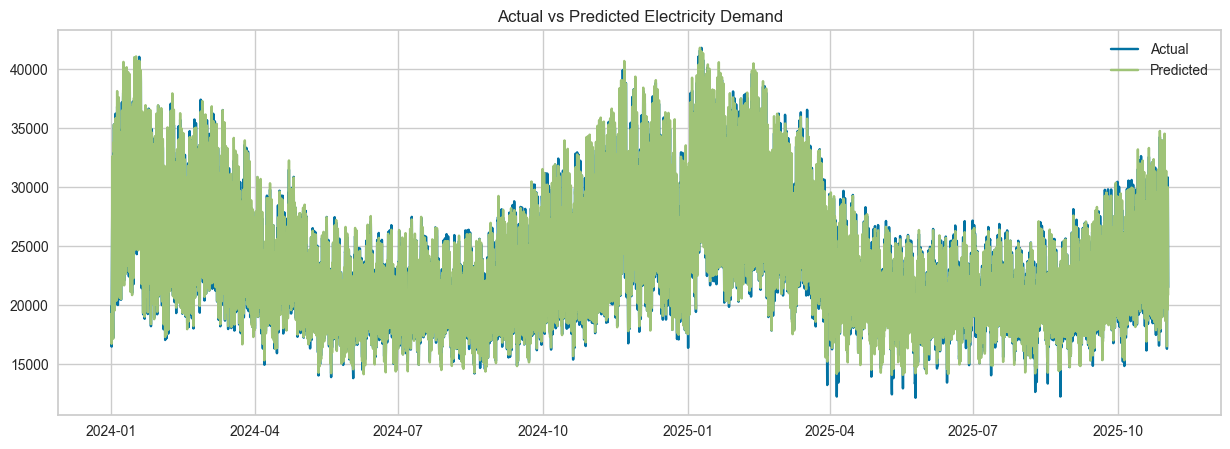

In [11]:
plt.figure(figsize=(15,5))
plt.plot(test.index, test["demand_mw"], label="Actual")
plt.plot(test.index, pred["prediction_label"], label="Predicted")
plt.title("Actual vs Predicted Electricity Demand")
plt.legend()
plt.show()


## 11. Visualization: Error Distribution

A well-behaved regression model has:

- symmetric errors

- centered around zero

- minimal extreme spikes

This checks model bias and variance.

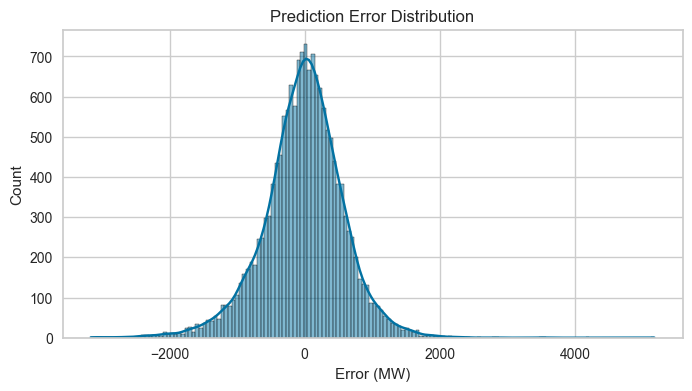

In [12]:
errors = test["demand_mw"] - pred["prediction_label"]

plt.figure(figsize=(8,4))
sns.histplot(errors, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Error (MW)")
plt.show()


## 12. Visualization: Actual vs Predicted Scatter Plot

Ideal prediction = points lie on the diagonal line.
This plot helps reveal:

- systematic bias

- under/over-prediction

- model stability

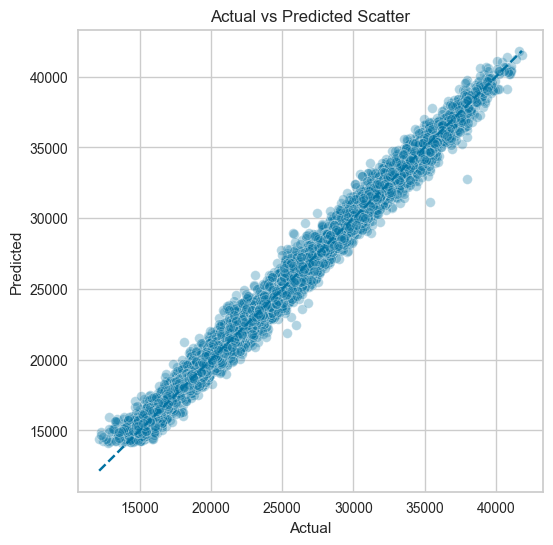

In [13]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=test["demand_mw"], y=pred["prediction_label"], alpha=0.3)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted Scatter")
plt.plot(
    [test["demand_mw"].min(), test["demand_mw"].max()],
    [test["demand_mw"].min(), test["demand_mw"].max()],
    linestyle="--"
)
plt.show()


## 13. Save Final Model for Deployment

Saving the model allows us to:

- Load it in the backend

- Build a prediction API

- Deploy it in Streamlit

- Use it without retraining

In [14]:
save_model(final_model, "../models/best_electricity_model_fast")


Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['hour', 'day_of_week', 'month',
                                              'week', 'is_weekend', 'lag_1',
                                              'lag_24', 'lag_168', 'roll_24',
                                              'roll_168'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=[],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('remove_multicolline...
                  TransformerWrapper(exclude=[],
                                     transformer=RemoveMulticollinearity(threshold=0.95))),
                 ('normalize', TransformerWrapper(transformer=StandardScaler())),
                 ('actual_estimator',
                  LGBMRegressor(bagging_fraction=0.8, bagging_freq=7,
      